In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower

from PurifyB import PurifyB
from Pseudo_Cl import Pseudo_Cl

from utils import smooth as smooth
from utils import deconv as deconv

import pymaster as nmt
import time
import utils

# functions

In [659]:
def plot_ps(cls, label):
#     plt.figure(figsize = (10,8));
    
    if len(cls.shape) == 1:
        _ell = np.arange(len(cls)); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2:], '-',label = label );
        
    else:
        _ell = np.arange(len(cls[0])); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[1][2:],label = 'EE');
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2][2:],label = 'BB');
    
    plt.legend(fontsize = 20);

    
ali_ma = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits', verbose=False)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

In [660]:
# ali_ma_512 = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits')
def Mask_0(maps_raw, mask):
    
    '''
    The masked values are equal to 0.
    '''
    maps = np.copy(maps_raw)
    index0 = np.arange(len(mask));
    mask_index0 = index0[np.where(mask<1)]
    
    _ndim = len(maps.shape)
    if _ndim > 2:  ### (Nf, 3, npix)
        for i in range(maps.shape[0]):
            for j in range(3):
                maps[i,j][mask_index0] = 0
    elif _ndim == 2: ### (3, npix)
        for j in range(maps.shape[0]):
            maps[j][mask_index0] = 0
    
    else: ### (npix)
        maps[mask_index0] = 0
    return maps

In [5]:
def Cross_TT(maps, lmax):
    
    ''' 
        revised for upper-triangle of the matrix 
        
    Input: spin-1 maps
    '''
    n_f = len(maps)
    cl = np.zeros((n_f*n_f, lmax + 1)); Cl = np.zeros((lmax+1, n_f, n_f))
    
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            if i >= j :
                cl[k] = hp.anafast(maps[i], maps[j], lmax = lmax)
            else:
                cl[k] = np.zeros(lmax+1)
            k += 1
            
    for l in range(lmax+1):
        Cl[l, 0:n_f , 0:n_f] = cl[:,l].reshape(n_f, n_f)
        Cl[l] += Cl[l].T - np.diag(Cl[l].diagonal()) 
    return Cl

# Check for Shamik

In [7]:
nside = 512; lmax = 1000

In [118]:
cls_0 = np.loadtxt('cls_r_0.txt'); cls_0p01 = np.loadtxt('cls_r_0p01.txt'); cls_0p05 = np.loadtxt('cls_r_0p05.txt'); cls_0p1 = np.loadtxt('cls_r_0p1.txt')

In [137]:
ali_ma512 = hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_wdge_512.fits', verbose=False)

mask = nmt.mask_apodization(ali_ma512, 6, apotype='C2') 

In [180]:
fsky = np.sum(ali_ma512)/12/nside**2

In [190]:
bl = hp.gauss_beam(19/60/180*np.pi, lmax = 3*nside)

In [191]:
SamNum = 100; Cls= []; b = nmt.NmtBin(nside, nlb=11, lmax=1000); Cls_real = []; Cls_all = []

for i in range(SamNum):
    
    if i < 3:
        start = time.time()
        
    cmb_real_1024_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%i, field = None, verbose = False)
    alms = hp.map2alm(cmb_real_1024_i)
    cmb_real_i = Mask_0(hp.alm2map(alms, nside = 512, fwhm=19/60/180*np.pi, verbose = False))
    
    cmb_clean_i = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%i, field = None, verbose = False)
    
    m_q, m_u = cmb_real_i[1] - cmb_clean_i[0], cmb_real_i[2] - cmb_clean_i[1]
    
    b_no_e = nmt.NmtField(mask, [m_q, m_u], purify_e=False, purify_b=True, beam=bl) 
    
    cl_i = nmt.compute_full_master(b_no_e, b_no_e,b) ## spin-2 x spin-2  # residuals
    
    b_real = nmt.NmtField(mask,cmb_real_i[1:], purify_e=False, purify_b=True, beam=bl)
    cl_real_i = nmt.compute_full_master(b_real, b_real, b) # real
    
    b_all = nmt.NmtField(mask, cmb_clean_i, purify_e=False, purify_b=True, beam=bl)  
    cl_all_i = nmt.compute_full_master(b_all, b_all, b) # cleaned
    
    Cls.append(cl_i[3]); Cls_real.append(cl_real_i[3]); Cls_all.append(cl_all_i[3])
    
    if i < 3:
        end = time.time()
        print('Time cost is: %s mins'%(end - start))
# cmb_clean = np.row_stack((np.ones(12*1024**2), cmb_clean))

Time cost is: 29.879783153533936 mins
Time cost is: 36.93956160545349 mins
Time cost is: 47.21826791763306 mins


In [192]:
ell_arr = b.get_effective_ells()

In [193]:
el2 = utils.l2(ell_arr)

Text(0, 0.5, '$\\delta D_{\\ell}^{BB}[\\mu K^2]$')

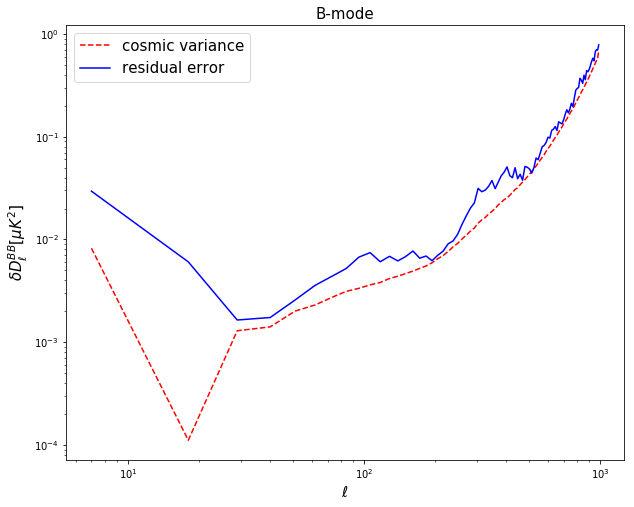

In [223]:
plt.loglog(ell_arr, np.sqrt(2/((2*ell_arr + 1)*fsky*11))*el2*np.mean(Cls_all, axis = 0), 'r--',label = 'cosmic variance')

# plt.loglog(ell_arr, el2*np.mean(Cls_real, axis = 0), 'g-',label = 'mean real')
plt.title('B-mode', fontsize = 15)
plt.loglog(ell_arr, el2*np.std(Cls, axis = 0), 'b-',label = 'residual error')
# plt.ylim(6*1e-4, 20)
plt.legend(fontsize = 15)
plt.xlabel('$\ell$', fontsize = 15); plt.ylabel('$\delta D_{\ell}^{BB}[\mu K^2]$', fontsize = 15)
# plt.xlim(20,)

# Namaster for ILC

In [385]:
beam_low = 19# 27.9435; 

nside = 512; lmax = 1000

b = nmt.NmtBin(nside, nlb=10, lmax=lmax); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)
bl = hp.gauss_beam(beam_low/60/180*np.pi, lmax = 3*nside)

In [386]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [114]:
ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)
mask = nmt.mask_apodization(ali_ma_512,  6, apotype='C2')
# hp.mollview(mask, title='Apodized mask')

In [387]:
cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(1), field = None, verbose = False)
alm_i = hp.map2alm(cmb_i); 
cmb_512_beam = hp.alm2map(alm_i, nside = nside, fwhm=beam_low/60/180*np.pi)
m0 = nmt.NmtField(mask, cmb_512_beam[1:], purify_e=False, purify_b=True)#, beam=bl)

Sigma is 8.068557 arcmin (0.002347 rad) 
-> fwhm is 19.000000 arcmin


In [388]:
# using workspace calculate the coupling matrix first.

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

In [389]:
SamNum = 100; Cl_cmb_BB = []; Cl_cmb_EE = []
for n in range(SamNum - 50):
    cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False)
    alm_i = hp.map2alm(cmb_i); 
    cmb_512_beam = hp.alm2map(alm_i, nside = nside, fwhm=beam_low/60/180*np.pi, verbose = False)
    
    m0 = nmt.NmtField(mask, cmb_512_beam[1:], purify_e=False, purify_b=True)#, beam=bl)
    
    cl_cross = compute_master(m0, m0, w)
    Cl_cmb_BB.append(cl_cross[3]); Cl_cmb_EE.append(cl_cross[0])

In [390]:
Cl_cmb_BB = np.array(Cl_cmb_BB); Cl_cmb_EE = np.array(Cl_cmb_EE)

In [391]:
cl_mean_bb = np.mean(Cl_cmb_BB, axis = 0)
cl_mean_ee = np.mean(Cl_cmb_EE, axis = 0)

In [392]:
np.save('/fnx/jianyao/cmb_0.05_realizations/cl_mean_namaster_95_with_beam.npy', np.row_stack((cl_mean_ee, cl_mean_bb)))

In [121]:
cl_hana = hp.anafast(cmb_i, nspec = 3, lmax = lmax)
ell = np.arange(len(cl_hana[2])); el2 = ell*(ell+1)/2/np.pi

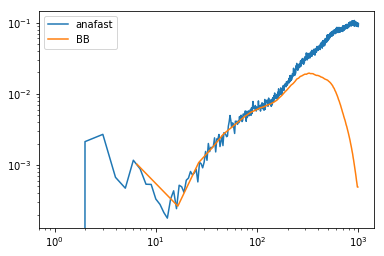

In [393]:
plt.loglog(ell,el2*cl_hana[2], label = 'anafast')
plt.loglog(ell_n, eln2*cl_mean_bb, label = 'BB')
plt.xlim(0.7,)
plt.legend()

# Correction for E-B leakage in pixel domain

In [742]:
cl_clean_patch = []; cl_clean_LH = []
for i in range(100):
    cmb_i = hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False)
    
    cl_patch_i = Patch_BB(cmb_i, 1024, ali_ma)
    cl_clean_patch.append(cl_patch_i); 
    
    puri_i = PurifyB(cmb_i, ali_ma);
    Bmap_i = puri_i.lin_resi()
    cl_LH_i = hp.anafast(Bmap_i, lmax = 1000)
    cl_clean_LH.append(cl_LH_i)

In [691]:
Cl_LH = np.mean(cl_clean_LH, axis = 0);
Cl_patch = np.mean(cl_clean_patch, axis = 0)

In [736]:
lh_std = np.std(cl_clean_LH, axis = 0)
patch_std = np.std(cl_clean_patch, axis = 0)

In [732]:
ell = np.arange(len(cl_LH_i)); el2 = utils.l2(ell)

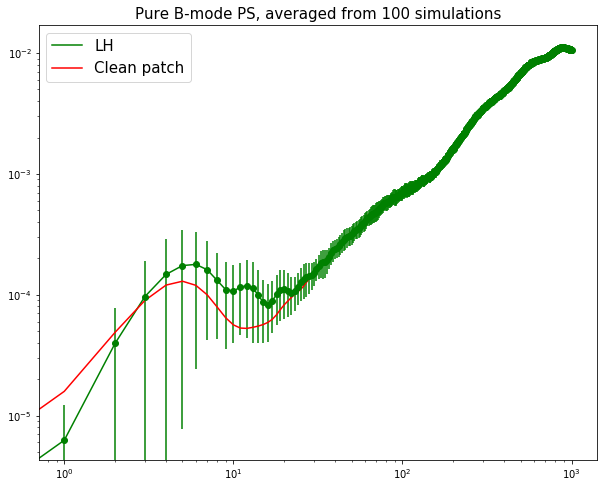

In [741]:
plt.figure(figsize = (10, 8))

plt.loglog(ell, el2*Cl_LH, 'g-',label = 'LH')
plt.loglog(ell, el2*Cl_patch, 'r-', label = 'Clean patch');

plt.errorbar(ell, el2*Cl_LH, yerr = el2*lh_std,fmt='go',capthick = 0.1)
# plt.errorbar(ell, el2*Cl_patch, yerr = el2*patch_std,fmt='bo',capthick = 0.1)


plt.title('Pure B-mode PS, averaged from 100 simulations', fontsize = 15)
plt.legend(fontsize = 15)

In [661]:
def Patch_BB(maps, nside, mask):
    
    '''
    Calculate the patch-sky Bmode from full sky BB maps.
    maps : pure CMB IQU
    '''
    alm_full = hp.map2alm(maps);
    Bmap_full = hp.alm2map(alm_full[2], nside = nside)

    Bmap_masked = Mask_0(Bmap_full, mask)
    cl_Bmap_masked = hp.anafast(Bmap_masked, lmax = 1000)
    
    return cl_Bmap_masked

Sigma is 8.068557 arcmin (0.002347 rad) 
-> fwhm is 19.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


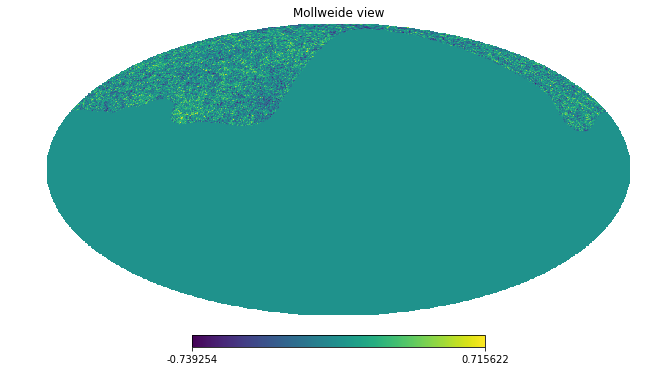

In [414]:
hp.mollview(hp.smoothing(Bmap_masked, fwhm  = 19/60/180*np.pi, lmax = lmax + 100 ))

In [378]:
cl_resi_hp = hp.anafast(map_resi, lmax = 1000)

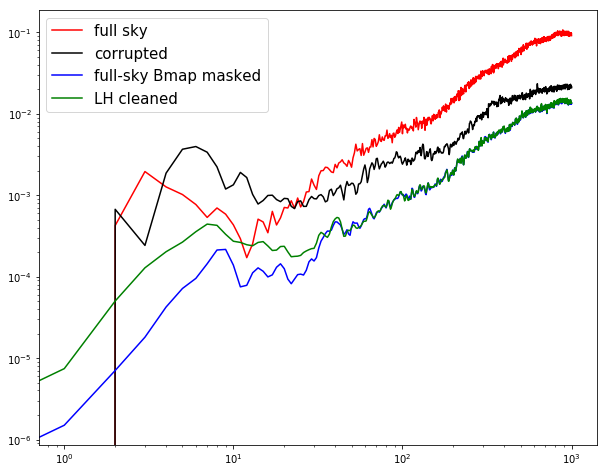

In [494]:
plt.figure(figsize = (10,8))

plt.loglog(ell, el2*cl_full[2],'r-', label = 'full sky')
plt.loglog(ell, el2*cl_cor_hp[2], 'k-',label = 'corrupted')
plt.loglog(ell, el2*cl_Bmap_masked, 'b-',label = 'full-sky Bmap masked')

plt.loglog(ell, el2*cl_resi_hp,'g-', label = 'LH cleaned')


plt.legend(fontsize = 15)

> get corrupted alm_TEB
 call map2alm_iterative(nside,lmax,lmax,niter,map,alm,mask=mask)

> get corrupted B-map
almB(1,:,:) = alm(3,:,:)
call alm2map (nside,lmax,mmax,almB,BO)

> get corrupted alm_E and convert to IQU
alm(1,:,:) = dcmplx(0,0)
alm(3,:,:) = dcmplx(0,0)
call alm2map (nside,lmax,mmax,alm,map)

> convert to alm with mask applied again
call map2alm_iterative(nside,lmax,lmax,niter,map,alm,mask=mask)

> get the leakage template
almB(1,:,:) = alm(3,:,:)
call alm2map (nside,lmax,mmax,almB,BT)

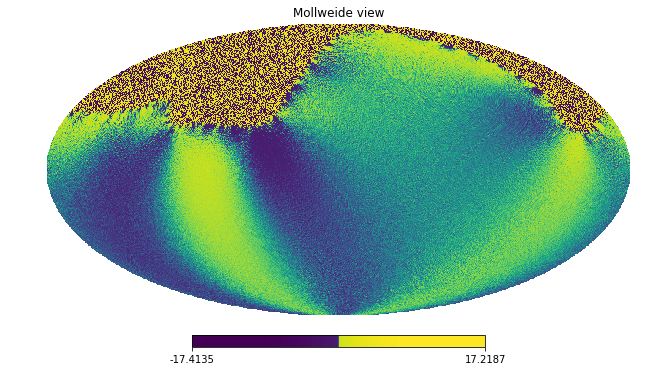

In [318]:
hp.mollview(map_E[2], norm = 'hist')#, cmap = 'coolwarm')

In [375]:
## mask info

n1 = sum(ali_ma_512); npix = np.arange(len(ali_ma_512)) 
list1 = npix[ali_ma_512 == 1] ### index of the available pixles

nside = 512; 

## get the template of E to B leakage 
alm_ma = hp.map2alm(cmb_masked) #alms of the masked maps

B0 = hp.alm2map(alm_ma[2], nside = nside, verbose = False) ## corrupted B map

alm_ma[0] = 0; alm_ma[2] = 0; map_E = hp.alm2map(alm_ma, nside, verbose = False) ### IQU of corrupted E mode only

alm_new = hp.map2alm(Mask_0(map_E))

BT = hp.alm2map(alm_new[2], nside = nside, verbose = False) ## template of E to B leakage 

In [181]:
def lin_resi(x, y, n):
    mx  = sum(x)/n; my  = sum(y)/n;
    cxx = sum((x-mx)*(x-mx)); cxy = sum((y-my)*(x-mx))
    a1  = cxy/cxx 
    a0  = my - mx*a1 
    resi  = y - a0 - a1*x
    
    map0 = np.zeros(12*nside**2);
    map0[list1] = resi
    
    return map0

In [376]:
map_resi = lin_resi(BT[list1], B0[list1], n1)

## namaster for the corrputed B -- May correct the E to B leakage automatically ???

In [769]:
m1 = nmt.NmtField(mask,[map_resi])

cl_resi = nmt.compute_full_master(m1, m1, b)

In [382]:
m2 = nmt.NmtField(mask,cmb_i[1:])

cl_cor = nmt.compute_full_master(m2, m2, b)

In [383]:
m3 = nmt.NmtField(mask,cmb_i[1:],purify_e=False, purify_b=True )
cl_puri = nmt.compute_full_master(m3, m3, b)

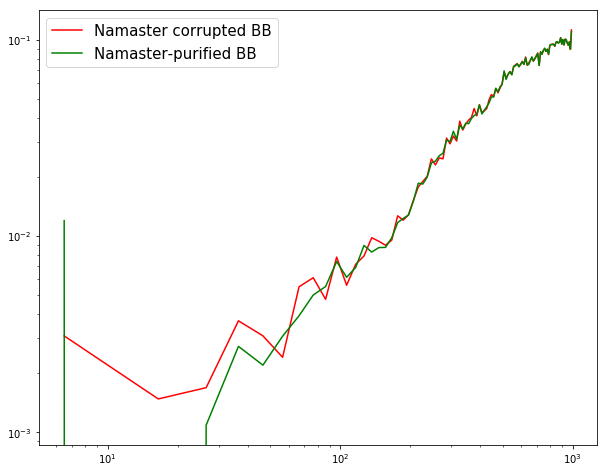

In [384]:
plt.figure(figsize = (10,8))
# plt.loglog(ell,el2*cl_full[2], 'g--',label = 'full-sky BB')
# plt.loglog(ell_n, eln2*cl_resi[0], 'b-',label = 'purified BB')
plt.loglog(ell_n, eln2*cl_cor[3], 'r-',label = 'Namaster corrupted BB')

plt.loglog(ell_n, eln2*cl_puri[3], 'g-',label = 'Namaster-purified BB')

plt.legend(fontsize = 15)

# Apply LH's method to the simulation data

## clean CMB BB maps

> apply Namaster to correct for the partial sky effect, after LH's method ; **2020.04.07**

In [853]:
nside = 512; lmax = 1000

b = nmt.NmtBin(nside, nlb=20, lmax=lmax); ell_n = b.get_effective_ells(); eln2 = utils.l2(ell_n)

ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)
mask = nmt.mask_apodization(mask_ring_512,  6, apotype='C2')  ## mask_ring_512; 2020.04.09

map0 = np.ones((12*nside**2))
m0 = nmt.NmtField(mask, [map0], purify_e=False, purify_b=True)  ##, beam=bl

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

SamNum = 100; Cl_BB = [];
for n in range(SamNum):
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False), nside_out = 512)
    
    cmb_beamed = smooth(cmb_i, beam_out = 19, lmax = 1500)#lmax + 100)
    
    purify = PurifyB(cmb_beamed, mask_ring_512); ## mask_ring_512; 2020.04.09
    CMB_Bmap = purify.lin_resi()

    m1 = nmt.NmtField(mask, [CMB_Bmap], purify_e=False, purify_b=True)
    
    clbb = compute_master(m1, m1, w)[0]
    
    Cl_BB.append(clbb)

In [854]:
cl_bb_mean = np.mean(Cl_BB, axis = 0)

In [855]:
np.save('/fnx/jianyao/cmb_0.05_realizations/ring_cl_bb_95GHz_LH_Namaster.npy', cl_bb_mean)

In [857]:
cl_bb_ali = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH_Namaster.npy')

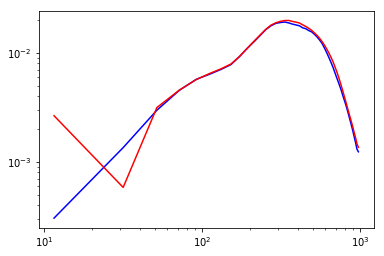

In [858]:
plt.loglog(ell_n, el2*cl_bb_mean, 'b-',label = 'Namaster after LH cleaned CMB')
plt.loglog(ell_n, el2*cl_bb_ali, 'r-',label = 'LH cleaned CMB')

## Foreground maps 

In [58]:
# g2_70 = hp.read_map('/fnx/jianyao/LFI_070/group2_map_detector_F070.fits',field = None, verbose = False)
# g3_70 = hp.read_map('/fnx/jianyao/LFI_070/group3_map_detector_F070.fits',field = None, verbose = False)


g2_95 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits',field = None, verbose = False)
# g3_95 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group3_map_95GHz.fits',field = None, verbose = False)
# g4_95 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group4_map_95GHz.fits',field = None, verbose = False)

g2_150 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits',field = None, verbose = False)
# # g3_150 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group3_map_150GHz.fits',field = None, verbose = False)
# # g4_150 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group4_map_150GHz.fits',field = None, verbose = False)

# g2_353 = hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits',field = None, verbose = False)
# # g3_353 = hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group3_map_detector_F353.fits',field = None, verbose = False)
# g4_353 = hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group4_map_detector_F353.fits',field = None, verbose = False)

In [87]:
#mK_CMB; nside = 2038; IQU maps;

g2_K = 1e3*hp.ud_grade(hp.read_map('/fnx/jianyao/WMAP/K/group2_map_K.fits', field = None), nside_out=512)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [27]:
bl = np.loadtxt('/fnx/jianyao/WMAP/wmap_ampl_bl_K1_9yr_v5p1.txt')

In [63]:
foreK = hp.smoothing(g2_K, beam_window=1.0/bl[:,1], lmax = 400)

Using provided beam window function
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


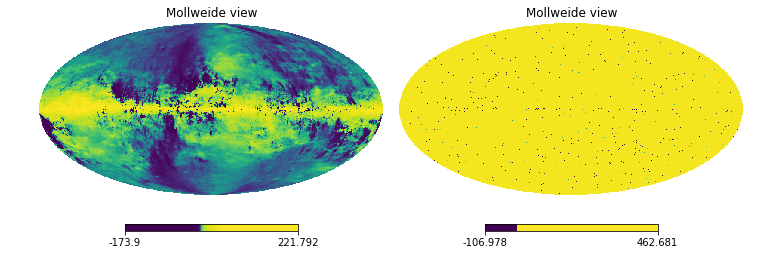

In [922]:
plt.figure(figsize = (10,8))
hp.mollview(g2_150[1], norm = 'hist', sub = (121)); hp.mollview(g4_150[2],norm = 'hist', sub = (122))

In [4]:
# # 13.0765 arcmin, K_CMB
# fore70 = hp.ud_grade(g2_70 , nside_out = 512)*1e6 #+ g3_70

# #27.9435 arcmin, K_CMB
# fore44 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_044/group2_map_detector_F044.fits', field = None, verbose = False), nside_out = 512)*1e6

### 19 arcmin, uK_CMB
fore95 = hp.ud_grade(g2_95 , nside_out=512)   #+ g3_95

### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(g2_150, nside_out=512)  #+ g3_150
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(g2_353, nside_out=512)*1e6  #+ g3_353

In [39]:
fore150_de = deconv(fore150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)

In [70]:
foreK_de = smooth(foreK, beam_out=beam_low, lmax = lmax)

In [65]:
lmax = 400

In [85]:
flK = hp.anafast(foreK_de*ali_ma_512, nspec = 3, lmax = lmax)

fl95 = hp.anafast(fore95*ali_ma_512, nspec = 3, lmax = lmax)
# fl95_23 = hp.anafast(fore95_g23, nspec = 3, lmax = lmax)

fl150 = hp.anafast(fore150_de*ali_ma_512, nspec=3, lmax = lmax)

# fl150_o = hp.anafast(fore150*ali_ma_512, nspec=3, lmax = lmax)
# fl150_23 = hp.anafast(fore150_g23, nspec=3, lmax = lmax)

In [68]:
ell = np.arange(len(fl95[0])); el2 = utils.l2(ell)

Text(0.5, 1.0, 'Foregrounds at 95 and 150 GHz')

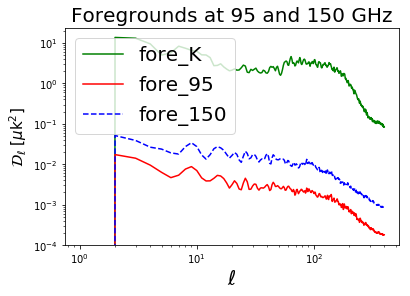

In [86]:
plt.loglog(ell, el2*flK[2], 'g-', label = 'fore_K')
plt.loglog(ell, el2*fl95[2], 'r-', label = 'fore_95')
plt.loglog(ell, el2*fl150[2], 'b--', label = 'fore_150')
# plt.loglog(ell, el2*fl150_o[2], 'g--', label = 'fore_150_o')

# plt.loglog(ell, el2*nl95, 'k-', label = 'noise_95')
# plt.loglog(ell, el2*nl150, 'k--', label = 'noise_150')

# plt.loglog(ell, el2*nl19[2], 'k--', label = 'noise_19 arcmin')


# plt.loglog(ell, el2*nl_150_o, 'k--', label = 'noise_150_o')

# plt.loglog(ell, el2*nl_95_o, 'b-', label = 'noise_95_o')


# plt.loglog(ell, el2*fl95_234[2], 'g--', label = 'group2 + 3 + 4')
plt.legend(fontsize = 20)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.title('Foregrounds at 95 and 150 GHz', fontsize = 20)

# plt.savefig('/home/jianyao/Ali_maps/results/0409_Namaster_after_LH/Foregrounds_at_95_150GHz.jpg', format = 'jpg')
# plt.loglog(ell, el2*fl150[2], 'r-')
# plt.loglog(ell, el2*fl150_23[2], 'b--')
# plt.loglog(ell, el2*fl150_234[2], 'g--')

# plt.loglog(fl353_234[2], 'k')

In [88]:
noiseK = hp.read_map('/fnx/jianyao/WMAP/Noise_K/map_p1_nmc100_K1.map_i', h = True, field = None)

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/home/jianyao/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


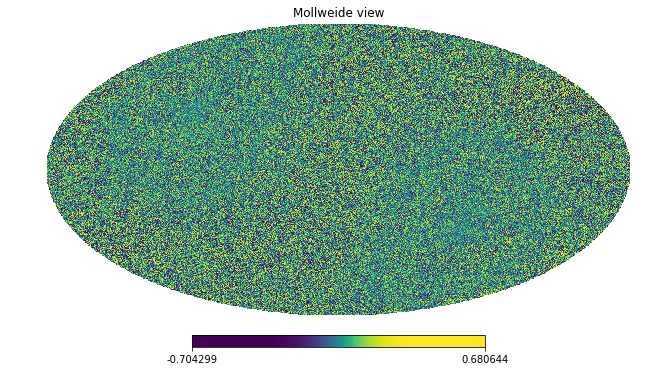

In [94]:
hp.mollview(noiseK[0][0], norm = 'hist')

In [1113]:
# noise_19 = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)
nl19 = hp.anafast(noise_150_de*ali_ma_512, nspec = 3, lmax = lmax)

In [1127]:
nl95 = 0; 
#nl150 = 0
for i in range(51, 100):
#     noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#     noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
#     noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
   
#     noise_150_de = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)
    
    nl95 += hp.anafast(noise_95*ali_ma_512, nspec = 3, lmax = lmax)[2];
#     nl150 += hp.anafast(noise_150_de*ali_ma_512, nspec = 3, lmax = lmax)[2];

nl95 = nl95/50.0;
nl150 = nl150/50.0;

In [1093]:
path = '/fnx/jianyao/ancillary_data/noise_ps/'

SamNum = 100; Q = len(ps_e.ell_n) #lmax + 1 
Nf  = 3
noise_ps_mean = 0 #np.zeros((Q, Nf, Nf))

for n in range(SamNum):
    noise_ps_mean += np.load('%s/nl_deconv_masked_EB_%s.npy'%(path, n))[1]

noise_ps_mean /= SamNum



## Total maps

In [833]:
mask_ring_512 = np.load('/fnx/jianyao/ancillary_data/mask_ring_512_6p2.npy')

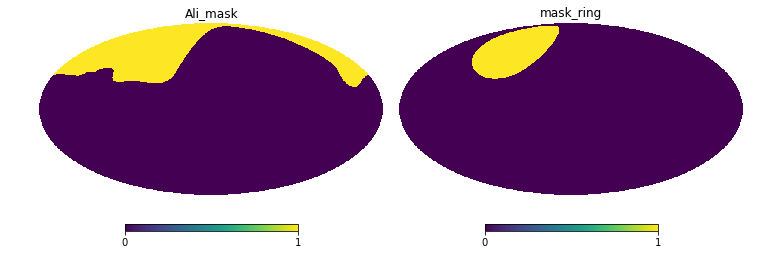

In [835]:
plt.figure(figsize = (10,8))
hp.mollview(ali_ma_512, title='Ali_mask', sub = (121)); hp.mollview(mask_ring_512, title = 'mask_ring', sub = (122))

In [9]:
ali_ma_512 = hp.read_map("/smc/jianyao/Ali_maps/ali_mask_wo_edge_512.fits", verbose=False)

In [4]:
ps_e = Pseudo_Cl(mask_in = ali_ma_512, nside = 512, bin_w = 20, lmax = 1000)

- Daily log


> 0406 Add group 3-faint point sources, apply Namaster after LH's meth: Group3_4_fre_LH_Namaster_noisy_95GHz_beam

> 0407 group2 only, apply namaster after LH's method: Group2_only_4_fre_LH_Namaster_noisy_95GHz_beam

> 0408- ring part with **anisotropic noise**, 4_fre, 70-95-150-353 : Ring_Group2_only_4_fre_LH_Namaster_noisy_95GHz_beam

> 0409- ring part with **isotropic noise**, 3_fre, 95-150-353 : Ring_Group2_only_4_fre_LH_Namaster_iso_noise_95GHz_beam

> 0409 - group4,3,2 for ali part; using LH's method; using Namaster-- Pseudo_cl.Cross_TT

> 0420 - using LH's method; using anafast-- Cross_TT

> 0421 - add WMAP K-band map

In [11]:
SamNum =100; beam_low = 19; Nf = 4; nside = 512; lmax = 400

## should use namaster instead; 2020-03-20 

for i in range(SamNum):
    if i < 50:
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    else: 
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    
#     noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/iso_95GHz/noise_95GHz_%s_512.fits'%i, field = None, verbose = False),nside_out = nside)
#     noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/iso_150GHz/noise_150GHz_%s_512.fits'%i, field = None, verbose = False),nside_out = nside)
    
    # mk_CMB, nside = 512,I map only
    noise_K = hp.read_map('/fnx/jianyao/WMAP/Noise_K/map_p1_nmc%s_K1.map_i'%i)*1e3
    
    # K_CMB, nside = 1024, IQU
#     noise_70 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/70GHz_LFI/70GHz_LFI_noise_070_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
#     noise_44 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/44GHz_LFI/noise_044_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
    Noise = np.zeros((Nf,3,12*nside**2)); Noise_B = np.zeros((Nf, 12*nside**2))
#     Noise[0] = noise_44;
#     Noise[0] = deconv(noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100);
    Noise[0] = smooth(hp.smoothing(noise_K,  beam_window=1.0/bl[:,1], lmax = lmax+10), beam_out = 19, lmax = lmax + 10)
    Noise[1] = noise_95;  
    Noise[2] = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 10); 
    Noise[3] = deconv(noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 10);

    for fre in range(Nf):
        
        purify_N = PurifyB(Noise[fre], ali_ma_512)  ### ring part of the Ali patch 
        Noise_B[fre] = purify_N.lin_resi()
    
    noise_bb_i = Cross_TT(Noise_B, lmax)
    np.save('/fnx/jianyao/ancillary_data/0421_wmapK/Nl_bb/nl_cross_bb_%s.npy'%i, noise_bb_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    
    total = np.zeros((Nf, 3, 12*nside**2)); total_Bmap = np.zeros((Nf, 12*nside**2))
#     total[0] = smooth(cmb_i, beam_out = beam_low, lmax = lmax + 100) + fore44 #+ noise_44 

#     total[0] = deconv(smooth(cmb_i, beam_out = 13.0765, lmax = lmax + 100) + fore70 + noise_70, beam_in = 13.0765, beam_out = beam_low, lmax = lmax + 100) #+ noise_70
    
    fn_K = hp.smoothing(g2_K + noise_K,  beam_window=1.0/bl[:,1], lmax = lmax+10)

    total[0] = smooth(cmb_i + fn_K, beam_out = 19, lmax = lmax + 10)
    
    total[1] = smooth(cmb_i, beam_out = 19, lmax = lmax + 10) + fore95 + noise_95 #(, beam_in = 19, beam_out = beam_low, lmax = lmax + 100) + noise_95
    
    total[2] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 10) + fore150 + noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100) #+ noise_150
    total[3] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 10) + fore353 + noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) #+ noise_353
    
    for fre in range(Nf):
        
        purify = PurifyB(total[fre], ali_ma_512)
        total_Bmap[fre] = purify.lin_resi()
        
#     np.save('/fnx/jianyao/ancillary_data/0420_ILC_P/total_map_unmasked/total_BBmap_deconv_unmasked_%03d.npy'%i, total_Bmap)
    
    cl_bb_i = Cross_TT(total_Bmap, lmax)
    
    np.save('/fnx/jianyao/ancillary_data/0421_wmapK/Cl_bb/cross_bb_%03d.npy'%i, cl_bb_i)

## ILC

In [5]:
path = '/fnx/jianyao/ancillary_data/Group4_3_fre_LH_Namaster_noisy_95GHz_beam/'

SamNum = 100; Q = len(ps_e.ell_n) #lmax + 1 
Nf  = 3
noise_ps_mean = np.zeros((Q, Nf, Nf))

for n in range(SamNum):
    noise_ps_mean += np.load('%s/Nl_bb/nl_cross_bb_%s.npy'%(path, n))

noise_ps_mean /= SamNum

# np.save('%s/Nl_bb/noise_ps_mean.npy'%path, noise_ps_mean)

In [7]:

# lmax = 1000,意味着有1001个l,Q应该等于1001; 想要得到干净的天图的时候，
names = ['Q_polarization', 'U_polarization']

sel = np.array((0, 1,2)); Nf = len(sel)

Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 1; #Fore_cl= np.zeros((SamNum, Q)); sync_cl = np.zeros((SamNum, Q)); dust_cl = np.zeros((SamNum, Q))
for n in range(SamNum): 

    e = np.matrix(np.ones(Nf))
    total_ps_i = np.load('%s/Cl_bb/cross_bb_%03d.npy'%(path, n)) ## only have BB power spectrum for the input maps are pure BB from LH's method.
   
    noise_bin_i = noise_ps_mean# utils.bin_l(noise_ps_mean[mode], lmax, Q); #
    noise_ilc = np.zeros(Q); 
    total_bin_i = total_ps_i #utils.bin_l(total_ps_i[mode], lmax, Q);
    
    # take some part of the cross power spectrum matrix
    total_bin = np.ones((Q, Nf,Nf)); noise_bin = np.ones((Q, Nf, Nf)); 
    for q in range(Q):
        x = 0; 
        for i in (sel):
            y = 0;
            for j in (sel):
                
                total_bin[q][x,y] = total_bin_i[q][i, j]
                noise_bin[q][x,y] = noise_bin_i[q][i, j]
                y += 1;
                
            x += 1;
            
    #calculate the weight
    W = np.matrix(np.zeros((Q, Nf)))

    for l in range(Q):
        norm = e*np.linalg.pinv((total_bin[l]))*e.T

        W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   

    for i in range(Q):

        ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''

        noise_ilc[i] = W[i,:]*(noise_bin[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
        Cl_ilc[n, i] = W[i,:]*(total_bin[i])*np.transpose(W[i,:]) - noise_ilc[i]  #1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) 


cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

cl_mean_std = np.row_stack((cl_ilc_mean, cl_ilc_std))

In [1076]:
# Ell = utils.get_ell(lmax, Q)
# el2 = utils.l2(Ell)

# Ell_clean = utils.get_ell(lmax, 50)
# el2_clean = utils.l2(Ell_clean)

Ell = ps_e.ell_n; el2 = utils.l2(Ell)

In [966]:
cl_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_bb_95GHz_LH_Namaster.npy')
# cl_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/ring_cl_bb_95GHz_LH_Namaster.npy')

In [868]:
cl_ilc_group3 = np.load('/home/jianyao/Ali_maps/results/Cleaned_PS/Cl_Group3_4_fre_LH_Namaster_noisy_95GHz_beam.npy')

Text(0.5, 1.0, 'Noisy')

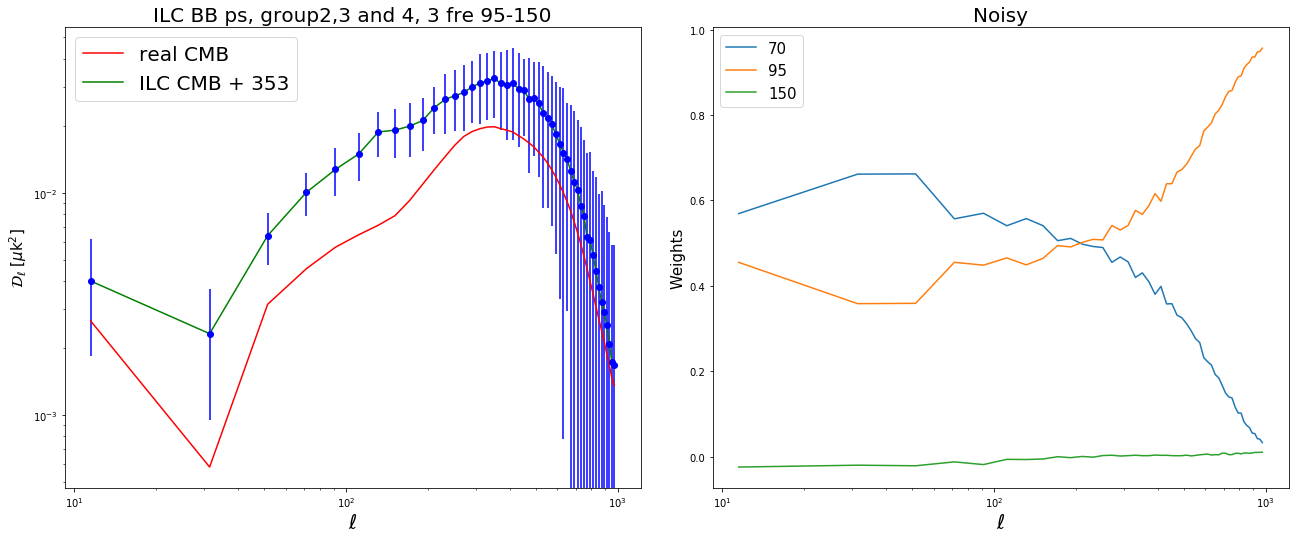

In [990]:
fig1 = plt.figure(1, figsize=(20,8)); psn = ['EE', 'BB']; fre = ['70','95','150','353']; 
# plt.axis('off')
frame1=fig1.add_axes((.1,.1,.4,.8)) # x0, y0, width, height

plt.plot(Ell, el2*cl_95, 'r-',label = 'real CMB')
# 
plt.plot(Ell, el2*(cl_ilc_mean), 'g-', label = 'ILC CMB + 353')
# plt.plot(Ell, el2*(cl_ilc_group3[0]), 'b-', label = 'ILC CMB + 70, 353, group3')


# plt.plot(Ell, el2*(cl_ilc_353), 'b-', label = 'ILC CMB +353')
# 

# plt.loglog(Ell,el2*noise_ilc, 'k--', label = 'noise_beamed_ilc')

# plt.plot(Ell, el2*(cl_ilc_mean - noise_ilc), label = 'noise debiased')

plt.xscale('log'); 
plt.yscale('log')
plt.errorbar(Ell, el2*cl_ilc_mean, yerr = el2*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell, el2*cl_ilc_353, yerr = el2*cl_std_353,fmt='go',capthick = 0.01)

# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20, loc = 'upper left')
# plt.grid()
plt.title('ILC %s ps, group2,3 and 4, %s fre 95-150'%(psn[mode], Nf), fontsize = 20)
# plt.ylim(2*1e-4, 40)
frame2=fig1.add_axes((.55,.1,.4,.8))
for i in range(Nf):
    plt.plot(Ell, W[:, i], label = '%s'%fre[sel[i]])
plt.xscale('log')
plt.legend(fontsize = 15)
plt.ylabel('Weights', fontsize = 15)
plt.xlabel('$\ell$', fontsize = 20); 
plt.title('Noisy',fontsize = 20)


# plt.savefig('/home/jianyao/Ali_maps/results/0409_Namaster_after_LH/Ring_noisy_%s.jpg'%psn[mode], format = 'jpg')

In [985]:
np.save('/home/jianyao/Ali_maps/results/Cleaned_PS/ILC_PS/Cl_group4_3_fre_LH_Namaster_noisy_95GHz_beam.npy', cl_mean_std)

## Compare results

In [986]:
cl_ilc_g2 = np.load('/home/jianyao/Ali_maps/results/Cleaned_PS/ILC_PS/Cl_Group2_only_3_fre_LH_Namaster_noisy_95GHz_beam.npy')
cl_ilc_g3 = np.load('/home/jianyao/Ali_maps/results/Cleaned_PS/ILC_PS/Cl_Group3_4_fre_LH_Namaster_noisy_95GHz_beam.npy')
cl_ilc_g4 = np.load('/home/jianyao/Ali_maps/results/Cleaned_PS/ILC_PS/Cl_group4_3_fre_LH_Namaster_noisy_95GHz_beam.npy')

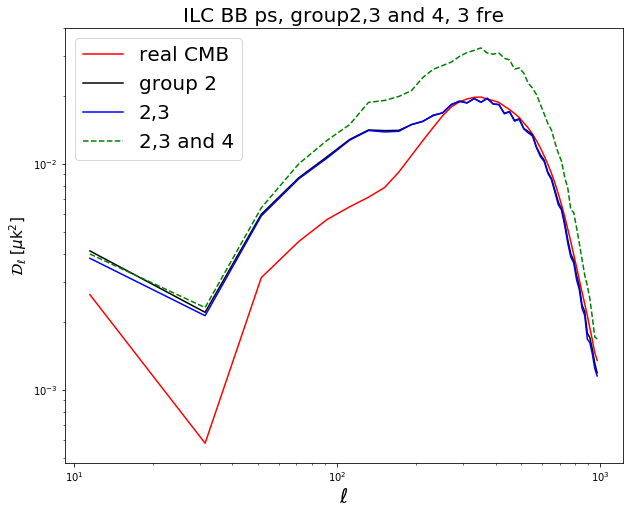

In [1000]:
fig1 = plt.figure(1, figsize=(10,8)); psn = ['EE', 'BB']; fre = ['70','95','150','353']; 

plt.plot(Ell, el2*cl_95, 'r-',label = 'real CMB')
plt.plot(Ell, el2*(cl_ilc_g2[0]), 'k-', label = 'group 2')
plt.plot(Ell, el2*(cl_ilc_g3[0]), 'b-', label = '2,3')
plt.plot(Ell, el2*(cl_ilc_g4[0]), 'g--', label = '2,3 and 4')

plt.xscale('log'); 
plt.yscale('log')
# plt.errorbar(Ell, el2*cl_ilc_mean, yerr = el2*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell, el2*cl_ilc_353, yerr = el2*cl_std_353,fmt='go',capthick = 0.01)

# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20, loc = 'upper left')
# plt.grid()
plt.title('ILC %s ps, group2,3 and 4, %s fre'%(psn[mode], Nf), fontsize = 20)
# plt.ylim(2*1e-4, 40)


plt.savefig('/home/jianyao/Ali_maps/results/0409_Namaster_after_LH/ILC_group234_%s.jpg'%psn[mode], format = 'jpg')

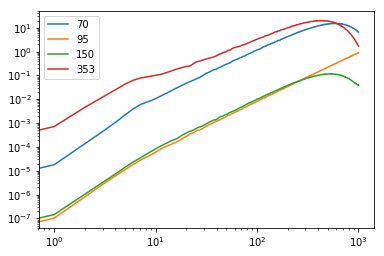

In [584]:
el2lmax = utils.l2(ell)

for i in range(Nf):
    
    plt.loglog(ell, el2lmax*noise_ps_mean[:,i, i], label = fre[i])
    
# plt.plot(Ell, el2*utils.bin_l(cl_bb_mean, lmax, Q), 'r-',label = 'real CMB')


plt.legend()

# ILC in pixel space, using ILC_P class

In [938]:
import ABS_ILC_class
imp.reload(ABS_ILC_class)

from ABS_ILC_class import ILC_P

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [1131]:
total = np.load('/fnx/jianyao/ancillary_data/total_map/total_map_deconv_unmasked_IQU_%03d.npy'%n)

In [1135]:
total.shape

(3, 3, 3145728)

# Class for E-B leakage

In [683]:
class PurifyB(object):
   
    def __init__(self, maps, mask):
         
        '''
        Parameters
        ----------
        
        mask : binary, 1 and 0;
        maps: IQU maps; The Mask_01() and hp.map2alm() require IQU as input.
        
        Example
        ----------
        
        purify = PurifyB(cmb_i, ali_ma_512)
        map_purified = purify.lin_resi()
        '''
        
        self.mask = mask; self.maps = maps; self.nside = hp.npix2nside(len(mask))
        self.pix_list = np.arange(len(mask)); self.mask_sum = sum(mask)
        self.mask_index = self.pix_list[np.where(mask == 0)] # the pixel index of the masked index
        self.avai_index = self.pix_list[np.where(mask == 1)] # the pixel index of the available index
        
    def Mask_01(self, maps_raw):
    
        '''
        Mask the maps. The masked values are equal to 0.
        maps_raw: the maps to be masked, the shape of which must be (Nf, 3, npix), (3, npix), or (npix).

        '''
        _maps = np.copy(maps_raw)

        _ndim = len(_maps.shape)

        if _ndim > 2:  ### (Nf, 3, npix)
            for i in range(_maps.shape[0]):
                for j in range(3):
                    _maps[i,j][self.mask_index] = 0
        elif _ndim == 2: ### (3, npix)
            for j in range(_maps.shape[0]):
                _maps[j][self.mask_index] = 0

        else: ### (npix)
            _maps[self.mask_index] = 0
        
        return _maps

    def lin_resi(self):
        
        '''
        Main function of this class to correct the E to B leakage.
        '''
        
        ### get the template of E to B leakage 
        
        alm_ma = hp.map2alm(self.Mask_01(self.maps)) #alms of the masked maps

        B0 = hp.alm2map(alm_ma[2], nside = self.nside, verbose = False) # corrupted B map
        
        alm_ma[0] = 0; alm_ma[2] = 0; map_E = hp.alm2map(alm_ma, nside = self.nside, verbose = False) # IQU of corrupted E mode only

        alm_new = hp.map2alm(self.Mask_01(map_E)) # alms of the IUQ from only E-mode 

        BT = hp.alm2map(alm_new[2], nside = self.nside, verbose = False) # template of E to B leakage 
        
        ### compute the residual of linear fit
        
        x = BT[self.avai_index]; y = B0[self.avai_index]
        
        mx  = sum(x)/self.mask_sum; my  = sum(y)/self.mask_sum;
        cxx = sum((x-mx)*(x-mx)); cxy = sum((y-my)*(x-mx))
        a1  = cxy/cxx 
        a0  = my - mx*a1 
        resi  = y - a0 - a1*x
        
        map0 = np.zeros(12*self.nside**2);
        map0[self.avai_index] = resi

        return map0

# Anisotropic and isotropic noise

In [71]:
n150cl = hp.anafast(noise_150, lmax = lmax)

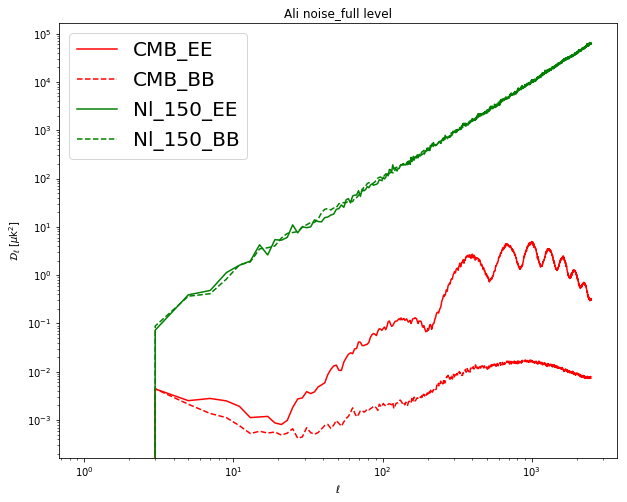

In [222]:
ell = np.arange(len(cmb_cl[0]))
plt.figure(figsize = (10,8))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[1]),'r', label = 'CMB_EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cl[2]),'r--', label = 'CMB_BB')
# plt.loglog(ell, ell*(ell+1)/2/np.pi*cmb_cl[2],'r--', label = 'CMB_BB')

# plt.subplot(121)
# plt.plot(ell, ell*(ell+1)/2/np.pi*ncl1, 'b-x')
# # # plt.subplot(122)
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[1]), 'k-', label = 'Nl_95_EE')
# plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(n2cl[2]), 'k--', label = 'Nl_95_BB')

plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[1]), 'g', label = 'Nl_150_EE')
plt.plot(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[2]), 'g--', label = 'Nl_150_BB')

plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Ali noise_full level')
plt.legend(fontsize = 20)
plt.savefig('./ps_full_area_cmb_noise.pdf', format = 'pdf')

In [213]:
white_noise = hp.read_map('/smc/jianyao/Ali_maps/full_white_noise_realization_150.fits', field = None)
wn_ma = Mask(white_noise)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [214]:
noise_150_full = hp.read_map('/smc/jianyao/Ali_maps/full_noise_realizations_150.fits',field = None, verbose=False)
noise_150_full_ma = Mask(noise_150_full)

In [215]:
#signal plus white noise
swn = cmb + white_noise
#signal plus anisotropic noise
sn = cmb + noise_150_full_ma

cmb_ma = Mask(cmb) 
sn_ma = Mask(sn) ; swn_ma = Mask(swn)

In [216]:
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)
sn_cls = hp.anafast(sn_ma, lmax = lmax, nspec = 3); 
nls = hp.anafast(noise_150_full_ma, lmax = lmax, nspec = 3)
swn_cls = hp.anafast(swn_ma, lmax = lmax, nspec = 3)
wnls = hp.anafast(wn_ma, lmax = lmax, nspec = 3)

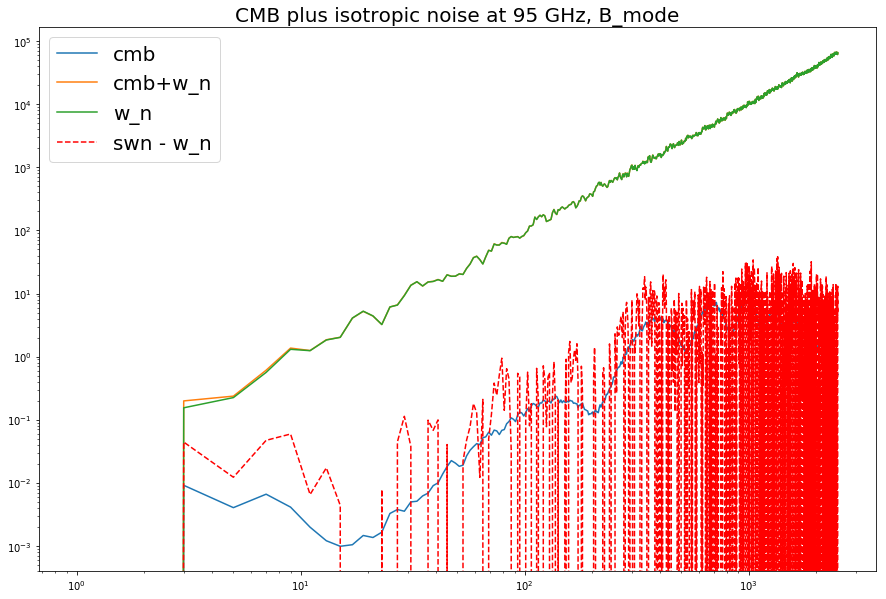

In [220]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0])); 
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), label = 'cmb')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(swn_cls[S]), label = 'cmb+w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(wnls[S]), label = 'w_n')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'r--',label = 'swn - w_n')
plt.title('CMB plus isotropic noise at 95 GHz, B_mode', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./cmb_white_noise_95_GHz_B.pdf', format = 'pdf')

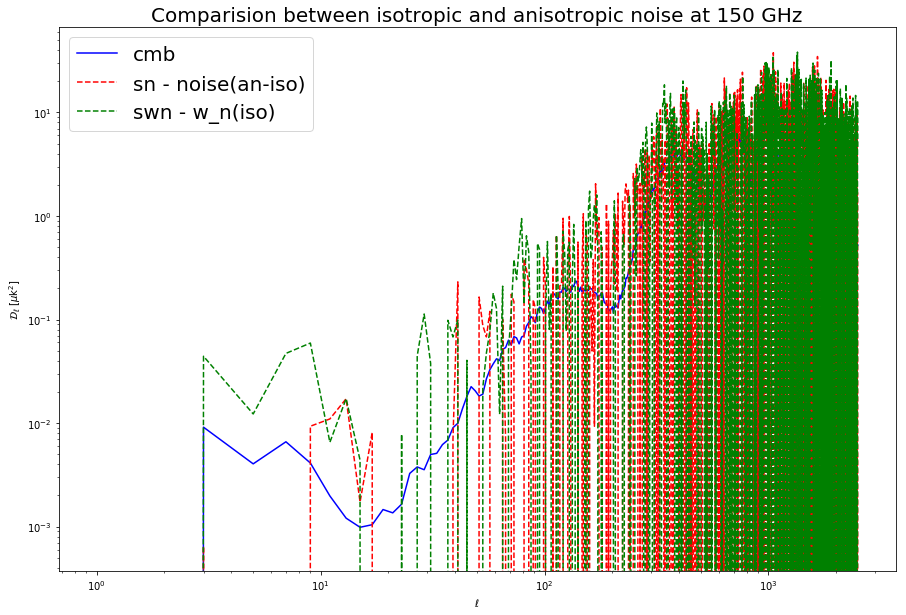

In [218]:
plt.figure(figsize = (15, 10)); S = 1
ell = np.arange(len(cmb_cls[0]))
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(cmb_cls[S]), 'b-',label = 'cmb')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(sn_cls[S]), label = 'cmb+noise')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(nls[S]), label = 'noise')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((sn_cls[S] - nls[S])), 'r--',label = 'sn - noise(an-iso)')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S])), 'g--',label = 'swn - w_n(iso)')
plt.xlabel('$\ell$'); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]')
plt.title('Comparision between isotropic and anisotropic noise at 150 GHz', fontsize = 20)
plt.legend(fontsize = 20)
# plt.savefig('./comparision_B_mode_150GHz.pdf', format = 'pdf')

In [138]:
# plt.figure(figsize = (15, 10));
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l((swn_cls[S] - wnls[S]) - (sn_cls[S] - nls[S])), 'r--',label = 'swn - w_n')
# plt.savefig('recovery_nosie_difference_95_Bmode.pdf', format = 'pdf')